In [61]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

In [62]:
df = pd.read_csv('cleaned_data.csv')
df = df[df['Credit_Score'].notna()]

/var/folders/p4/jnb87qbx4_d13sj5n8tn96vw0000gn/T/ipykernel_10508/1306290490.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')


In [63]:
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(cat_cols)
print(f"Number of categorical columns: {len(cat_cols)}")

['ID', 'Customer_ID', 'Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']
Number of categorical columns: 10


In [64]:
one_hot_columns = ['Month', 'Occupation', 'Type_of_Loan', 'Credit_History_Age', 'Payment_Behaviour']
label_columns = ['Credit_Mix', 'Payment_of_Min_Amount']

In [65]:
le = LabelEncoder()
for col in label_columns:
    df[col] = le.fit_transform(df[col].astype(str))


df = pd.get_dummies(df, columns=one_hot_columns, drop_first=True)

print(df.head())

       ID Customer_ID        Age  Annual_Income  Monthly_Inhand_Salary  \
0  0x1602   CUS_0xd40  23.000000       19114.12            1824.843333   
1  0x1603   CUS_0xd40  23.000000       19114.12            1824.843333   
2  0x1604   CUS_0xd40  23.272727       19114.12            1824.843333   
3  0x1605   CUS_0xd40  23.000000       19114.12            1824.843333   
4  0x1606   CUS_0xd40  23.000000       19114.12            1824.843333   

   Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
0                3.0              4.0            3.0          4.0   
1                3.0              4.0            3.0          4.0   
2                3.0              4.0            3.0          4.0   
3                3.0              4.0            3.0          4.0   
4                3.0              4.0            3.0          4.0   

   Delay_from_due_date  ...  Credit_History_Age_9 Years and 5 Months  \
0             3.000000  ...                                    False

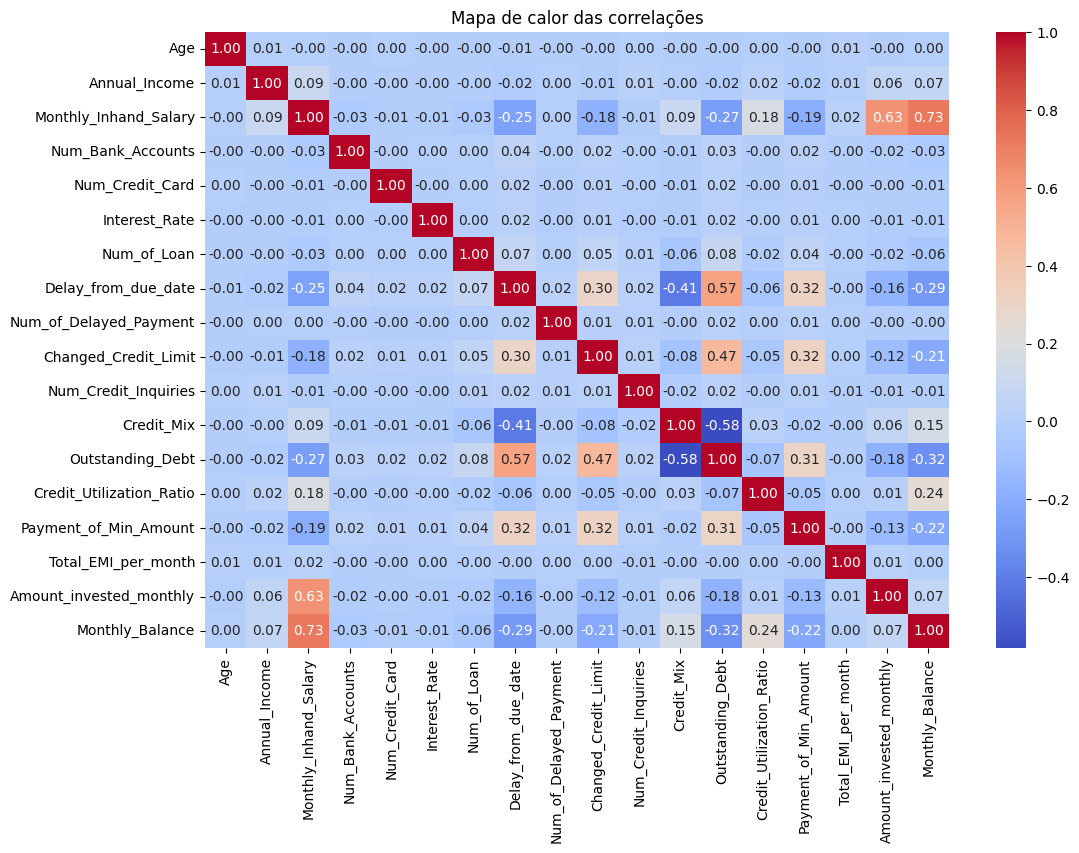

In [66]:
num_df = df.select_dtypes(include=[np.number])
corr_matrix = num_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de calor das correlações")
plt.show()

In [67]:
high_corr = (
    corr_matrix
    .abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr.columns = ['coluna_1', 'coluna_2', 'correlacao']
result = high_corr[high_corr['correlacao'] > 0.5]

# Pega os nomes das colunas envolvidas
cols_corr = set(result['coluna_1']).union(set(result['coluna_2']))

# Cria novo DataFrame só com essas colunas
df_high_corr = df[list(cols_corr)]

print(df_high_corr.columns)

Index(['Delay_from_due_date', 'Credit_Mix', 'Amount_invested_monthly',
       'Outstanding_Debt', 'Monthly_Inhand_Salary', 'Monthly_Balance'],
      dtype='object')


In [68]:
for col in df_high_corr.columns:
    min_val = df_high_corr[col].min()
    max_val = df_high_corr[col].max()
    print(f"Coluna: {col}, Min: {min_val}, Max: {max_val}")

Coluna: Delay_from_due_date, Min: 0.0, Max: 67.0
Coluna: Credit_Mix, Min: 0, Max: 2
Coluna: Amount_invested_monthly, Min: 0.0, Max: 1944.5207468791525
Coluna: Outstanding_Debt, Min: 0.23, Max: 4998.07
Coluna: Monthly_Inhand_Salary, Min: 303.6454166666666, Max: 15204.633333333331
Coluna: Monthly_Balance, Min: 0.0077596647753352, Max: 1576.2889354369515


In [69]:
scaler = MinMaxScaler()
df_high_corr_scaled = pd.DataFrame(
    scaler.fit_transform(df_high_corr),
    columns=df_high_corr.columns
)

print(df_high_corr_scaled.describe())

       Delay_from_due_date    Credit_Mix  Amount_invested_monthly  \
count         95695.000000  95695.000000             95695.000000   
mean              0.314628      0.610507                 0.097368   
std               0.221280      0.402355                 0.096321   
min               0.000000      0.000000                 0.000000   
25%               0.149254      0.500000                 0.037629   
50%               0.268657      0.500000                 0.066073   
75%               0.417910      1.000000                 0.118839   
max               1.000000      1.000000                 1.000000   

       Outstanding_Debt  Monthly_Inhand_Salary  Monthly_Balance  
count      95695.000000           95695.000000     95695.000000  
mean           0.285319               0.261218         0.258946  
std            0.231085               0.213853         0.135332  
min            0.000000               0.000000         0.000000  
25%            0.113202               0.088783  

In [70]:
df = df.drop(columns=["ID", "Customer_ID"])

In [71]:
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

model = RandomForestClassifier(
    n_estimators=50,      
    max_depth=10,         
    max_features='sqrt',  
    n_jobs=-1,
    random_state=42
)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

Outstanding_Debt                                                                                                                                                       0.088543
Credit_Mix                                                                                                                                                             0.083837
Num_Bank_Accounts                                                                                                                                                      0.083240
Interest_Rate                                                                                                                                                          0.075914
Payment_of_Min_Amount                                                                                                                                                  0.075351
                                                                                                                        

In [72]:
important_features = importances[importances > 0.06]
print(important_features.sort_values(ascending=False))

X_important = X[important_features.index]
print(X_important.head())
print(X_important.shape)

Outstanding_Debt         0.088543
Credit_Mix               0.083837
Num_Bank_Accounts        0.083240
Interest_Rate            0.075914
Payment_of_Min_Amount    0.075351
Num_of_Loan              0.072717
Delay_from_due_date      0.071079
Monthly_Balance          0.061058
dtype: float64
   Num_Bank_Accounts  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0                3.0            3.0          4.0             3.000000   
1                3.0            3.0          4.0             3.666667   
2                3.0            3.0          4.0             3.000000   
3                3.0            3.0          4.0             5.000000   
4                3.0            3.0          4.0             6.000000   

   Credit_Mix  Outstanding_Debt  Payment_of_Min_Amount  Monthly_Balance  
0           1            809.98                      1       312.494089  
1           1            809.98                      1       284.629162  
2           1            809.98                     

In [73]:
df_important = df[important_features.index]
print(df_important.head())
print(df_important.shape)

   Num_Bank_Accounts  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0                3.0            3.0          4.0             3.000000   
1                3.0            3.0          4.0             3.666667   
2                3.0            3.0          4.0             3.000000   
3                3.0            3.0          4.0             5.000000   
4                3.0            3.0          4.0             6.000000   

   Credit_Mix  Outstanding_Debt  Payment_of_Min_Amount  Monthly_Balance  
0           1            809.98                      1       312.494089  
1           1            809.98                      1       284.629162  
2           1            809.98                      1       331.209863  
3           1            809.98                      1       223.451310  
4           1            809.98                      1       341.489231  
(95695, 8)


In [74]:
X_imp = df_important
y_imp = df.loc[X_imp.index, 'Credit_Score']

print("NaNs em X_imp por coluna:")
print(X_imp.isna().sum())

print("\nTotal de linhas com algum NaN em X_imp:", X_imp.isna().any(axis=1).sum())

print("\nNaNs em y_imp:", y_imp.isna().sum())
print("\nÍndices com NaN em y_imp:", y_imp[y_imp.isna()].index.tolist())

NaNs em X_imp por coluna:
Num_Bank_Accounts        0
Interest_Rate            0
Num_of_Loan              0
Delay_from_due_date      0
Credit_Mix               0
Outstanding_Debt         0
Payment_of_Min_Amount    0
Monthly_Balance          0
dtype: int64

Total de linhas com algum NaN em X_imp: 0

NaNs em y_imp: 0

Índices com NaN em y_imp: []


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)

model_imp = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
model_imp.fit(X_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [76]:
y_pred = model_imp.predict(X_test)

print('Acurácia:', accuracy_score(y_test, y_pred))
print('Precisão:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))
print('\nRelatório de classificação:')
print(classification_report(y_test, y_pred))

Acurácia: 0.7017608025497675
Precisão: 0.729921734960217
Recall: 0.7017608025497675
F1-score: 0.7063438559154964

Relatório de classificação:
              precision    recall  f1-score   support

        Good       0.52      0.80      0.63      3413
        Poor       0.71      0.71      0.71      5544
    Standard       0.81      0.66      0.73     10182

    accuracy                           0.70     19139
   macro avg       0.68      0.73      0.69     19139
weighted avg       0.73      0.70      0.71     19139



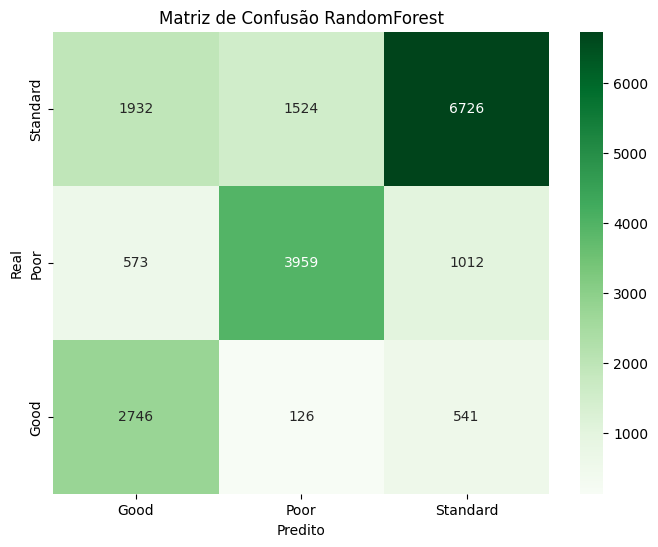

In [88]:
labels = ['Standard', 'Poor', 'Good']
labels_inv = labels[::-1]
cm_rf = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf[:, ::-1], annot=True, fmt='d', cmap='Greens', xticklabels=labels_inv, yticklabels=labels)
plt.title('Matriz de Confusão RandomForest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [78]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))
print('Precisão SVM:', precision_score(y_test, y_pred_svm, average='weighted'))
print('Recall SVM:', recall_score(y_test, y_pred_svm, average='weighted'))
print('F1-score SVM:', f1_score(y_test, y_pred_svm, average='weighted'))
print('\nMatriz de confusão SVM:')
print(confusion_matrix(y_test, y_pred_svm))

print('\nRelatório de classificação SVM:')
print(classification_report(y_test, y_pred_svm))

Acurácia SVM: 0.6058832749882439
Precisão SVM: 0.5087764267351612
Recall SVM: 0.6058832749882439
F1-score SVM: 0.5366623612020672

Matriz de confusão SVM:
[[   0   39 3374]
 [   0 2631 2913]
 [   0 1217 8965]]

Relatório de classificação SVM:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00      3413
        Poor       0.68      0.47      0.56      5544
    Standard       0.59      0.88      0.70     10182

    accuracy                           0.61     19139
   macro avg       0.42      0.45      0.42     19139
weighted avg       0.51      0.61      0.54     19139

              precision    recall  f1-score   support

        Good       0.00      0.00      0.00      3413
        Poor       0.68      0.47      0.56      5544
    Standard       0.59      0.88      0.70     10182

    accuracy                           0.61     19139
   macro avg       0.42      0.45      0.42     19139
weighted avg       0.51      0.61      0.54     19

/Users/enzoporto/Desktop/Faculdade/CienciaDados/GB/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/enzoporto/Desktop/Faculdade/CienciaDados/GB/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/enzoporto/Desktop/Faculdade/CienciaDados/GB/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

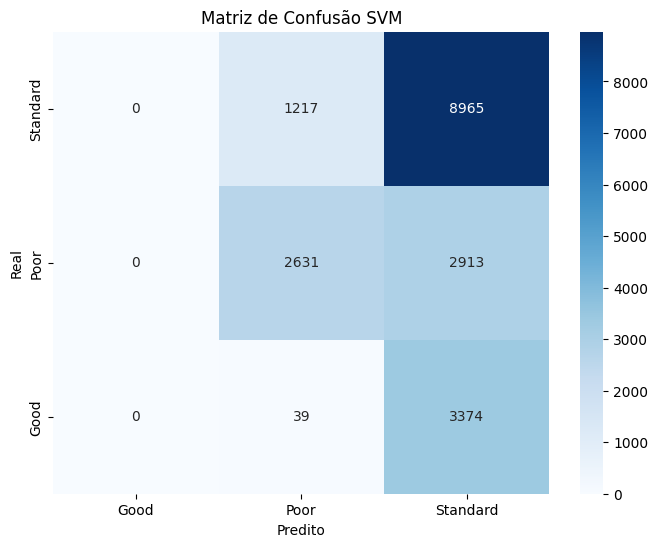

In [87]:
labels = ['Standard', 'Poor', 'Good']
labels_inv = labels[::-1]
cm = confusion_matrix(y_test, y_pred_svm, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm[:, ::-1], annot=True, fmt='d', cmap='Blues', xticklabels=labels_inv, yticklabels=labels)
plt.title('Matriz de Confusão SVM')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [81]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

le_target = LabelEncoder()
y_train_enc = le_target.fit_transform(y_train)
y_test_enc = le_target.transform(y_test)

xgb_model.fit(X_train, y_train_enc)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_labels = le_target.inverse_transform(y_pred_xgb)

print('Acurácia XGBoost:', accuracy_score(y_test_enc, y_pred_xgb))
print('Precisão XGBoost:', precision_score(y_test_enc, y_pred_xgb, average='weighted'))
print('Recall XGBoost:', recall_score(y_test_enc, y_pred_xgb, average='weighted'))
print('F1-score XGBoost:', f1_score(y_test_enc, y_pred_xgb, average='weighted'))
print('\nRelatório de classificação XGBoost:')
print(classification_report(y_test_enc, y_pred_xgb, target_names=le_target.classes_))

Acurácia XGBoost: 0.7540101363707613
Precisão XGBoost: 0.7615688304759238
Recall XGBoost: 0.7540101363707613
F1-score XGBoost: 0.7560017899005363

Relatório de classificação XGBoost:
              precision    recall  f1-score   support

        Good       0.62      0.75      0.68      3413
        Poor       0.76      0.76      0.76      5544
    Standard       0.81      0.75      0.78     10182

    accuracy                           0.75     19139
   macro avg       0.73      0.75      0.74     19139
weighted avg       0.76      0.75      0.76     19139



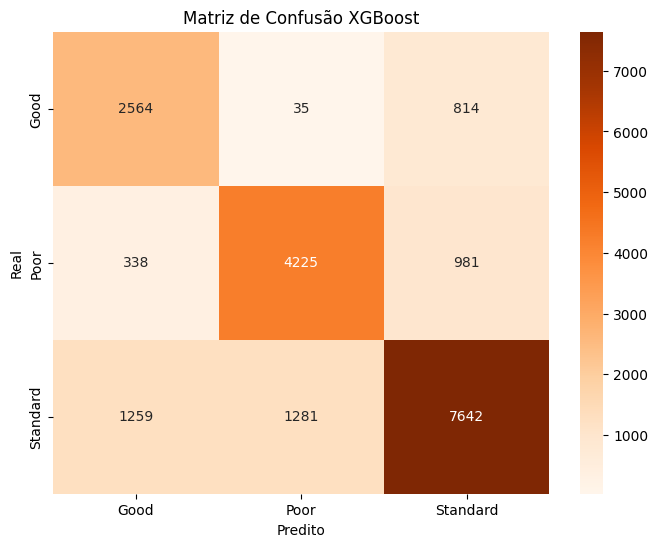

In [ ]:
# Matriz de confusão bonita para XGBoost (Good na base e coluna direita)
labels = le_target.classes_
labels_inv = labels[::-1]
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb, labels=range(len(labels)))
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb[:, ::-1], annot=True, fmt='d', cmap='Oranges', xticklabels=labels_inv, yticklabels=labels)
plt.title('Matriz de Confusão XGBoost (Good na base e coluna)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()